# finepdf怎么决定是否要ocr？
判断标准: `ocr_prob >= 0.2` 或 `garbled_text_ratio > 0`

### ocr_prob的阈值：orc class 召回率和预期时间的平衡
假设OCR每页需要5秒，计算需要ocr的总页数，然后得到天数。他们用了24*8 GPU

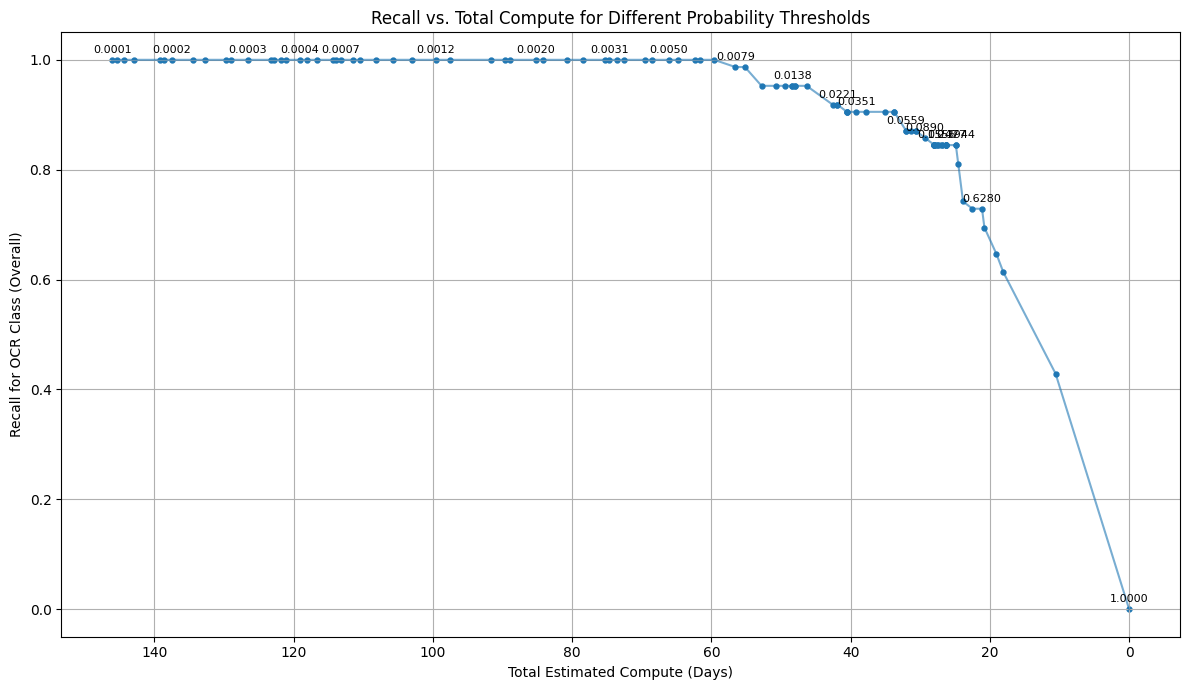

### `garbled_text_ratio`： 提取出来的 `0xfffd（ �）`的比例

 ```python
def get_garbled_text_per_age(self, doc: pymupdf.Document):
    all_text = []
    garbled_text = []
    for page in doc:
        page_text = page.get_text("text", flags=pymupdf.TEXT_PRESERVE_WHITESPACE | pymupdf.TEXT_MEDIABOX_CLIP)
        all_text.append(len(page_text))
        garbled_text.append(page_text.count(chr(0xfffd)))

    return all_text, garbled_text
```


# 对5000+文件的eda

In [2]:
import pandas as pd
import pymupdf
import numpy as np
import re
import json
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/Users/wanglibei/Desktop/MNBVC/list_01_09.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5295 entries, 0 to 5294
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   path             5295 non-null   object 
 1   ocr_probability  5295 non-null   float64
 2   file_size_bytes  5295 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 124.2+ KB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5295 entries, 0 to 5294
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   path             5295 non-null   object 
 1   ocr_probability  5295 non-null   float64
 2   file_size_bytes  5295 non-null   int64  
 3   file_size_MB     5295 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 165.6+ KB


In [7]:
df.describe()

,ocr_probability,file_size_bytes,file_size_MB
count,5295.000000,5.295000e+03,5295.000000
mean,0.521653,2.188034e+06,2.086671
std,0.269593,7.387385e+06,7.045160
min,0.100024,6.300000e+01,0.000060
25%,0.252026,1.089960e+05,0.103947
50%,0.572066,4.238610e+05,0.404225
75%,0.791125,1.480958e+06,1.412351
max,0.899669,1.915571e+08,182.683091


## 文件大小分布

In [5]:
df['file_size_MB'] = df['file_size_bytes'] / (1024 * 1024)


In [8]:
df["file_size_MB"].quantile([0.5,0.9,0.99,0.999])

0.500     0.404225
0.900     4.572444
0.990    27.069421
0.999    91.867101
Name: file_size_MB, dtype: float64

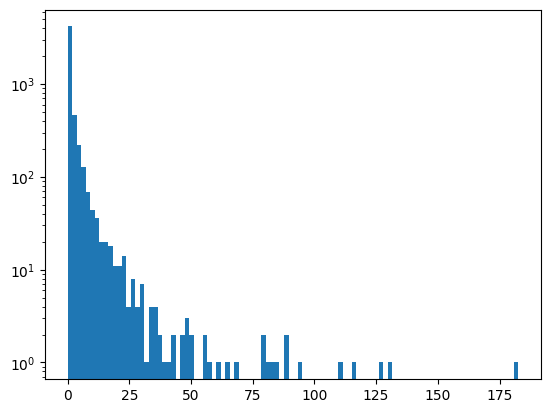

In [10]:
fig, ax = plt.subplots()
ax.hist(df["file_size_MB"], bins=100, log=True);

<Axes: xlabel='file_size_MB', ylabel='Density'>

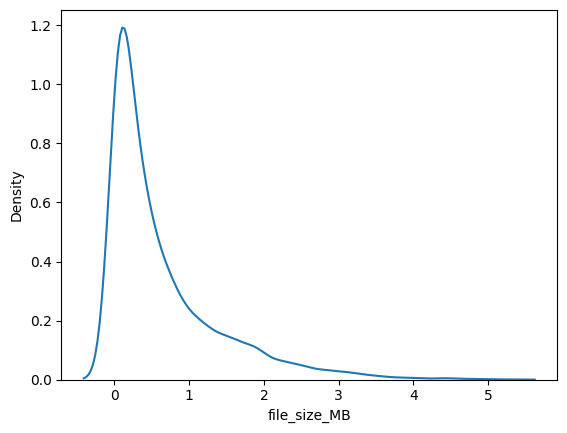

In [11]:
import seaborn as sns
sns.kdeplot(np.log1p(df["file_size_MB"]))

### 文件分桶

In [12]:
bins = [0, 5, 50, float("inf")]
labels = ["0-5MB", "5-50MB", ">=50MB"]
df["size_bucket"] = pd.cut(
    df["file_size_MB"], bins=bins, labels=labels, right=False)

In [13]:
df.size_bucket.value_counts().sort_index()

size_bucket
0-5MB     4811
5-50MB     463
>=50MB      21
Name: count, dtype: int64

## 总体ocr_prob分布

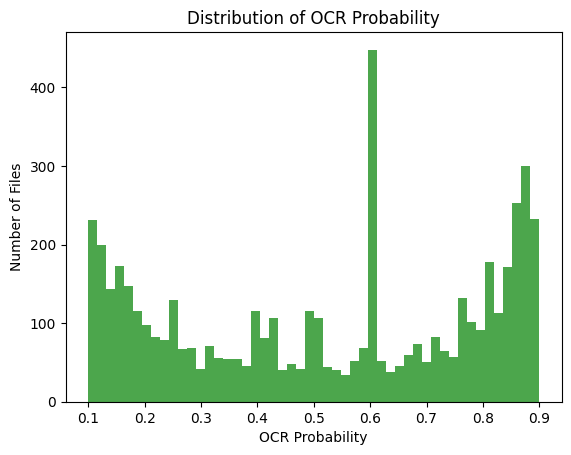

In [14]:
fig, ax = plt.subplots()
plt.hist(df["ocr_probability"], bins=50, color='green', alpha=0.7)
plt.title('Distribution of OCR Probability')
plt.xlabel('OCR Probability')
plt.ylabel('Number of Files')
plt.show()

<Axes: xlabel='ocr_probability', ylabel='Density'>

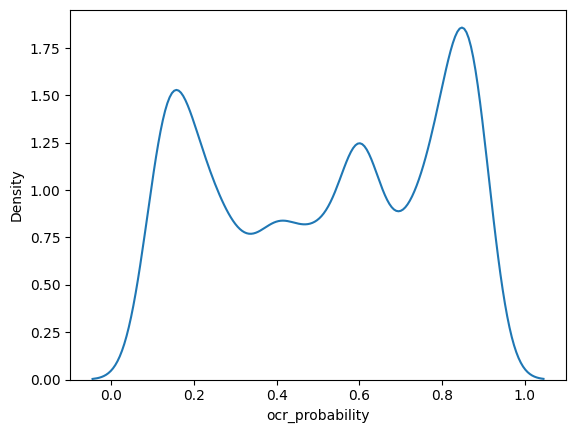

In [15]:
sns.kdeplot(df["ocr_probability"])

In [16]:
prob_low = (df["ocr_probability"] < 0.3).mean()
prob_mid = ((df["ocr_probability"] >= 0.3) & (df["ocr_probability"] <= 0.7)).mean()
prob_high = (df["ocr_probability"] > 0.7).mean()
print(f"Proportion of files with OCR probability < 0.3: {prob_low:.2%}")
print(f"Proportion of files with OCR probability between 0.3 and 0.7: {prob_mid:.2%}")
print(f"Proportion of files with OCR probability > 0.7: {prob_high:.2%}")

Proportion of files with OCR probability < 0.3: 29.31%
Proportion of files with OCR probability between 0.3 and 0.7: 36.69%
Proportion of files with OCR probability > 0.7: 33.99%


## 对于不同大小的文件，prob是否稳定？

In [17]:
df.groupby("size_bucket")["ocr_probability"].describe()

/var/folders/8h/qygchvl97sd_mr0kglftbvp80000gn/T/ipykernel_54758/2749542321.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("size_bucket")["ocr_probability"].describe()


,count,mean,std,min,25%,50%,75%,max
size_bucket,,,,,,,,
0-5MB,4811.0,0.511934,0.269858,0.100024,0.241718,0.536543,0.778644,0.899669
5-50MB,463.0,0.617473,0.246505,0.101259,0.433970,0.692614,0.834451,0.897591
>=50MB,21.0,0.635461,0.268190,0.137788,0.428492,0.748189,0.864046,0.892286


In [18]:
df.groupby("size_bucket")["ocr_probability"].quantile([0.1, 0.5,0.9]).unstack()

/var/folders/8h/qygchvl97sd_mr0kglftbvp80000gn/T/ipykernel_54758/3670324243.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("size_bucket")["ocr_probability"].quantile([0.1, 0.5,0.9]).unstack()


,0.1,0.5,0.9
size_bucket,,,
0-5MB,0.140334,0.536543,0.864670
5-50MB,0.198466,0.692614,0.877074
>=50MB,0.184599,0.748189,0.884536


<Axes: xlabel='size_bucket', ylabel='ocr_probability'>

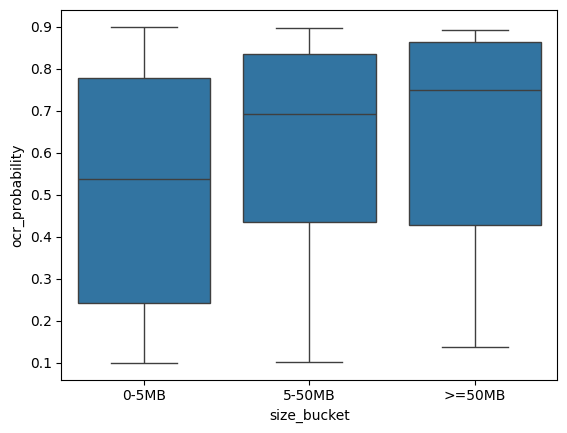

In [19]:
sns.boxplot(x="size_bucket", y="ocr_probability",
            data=df, order=["0-5MB", "5-50MB", ">=50MB"])


<Axes: xlabel='size_bucket', ylabel='ocr_probability'>

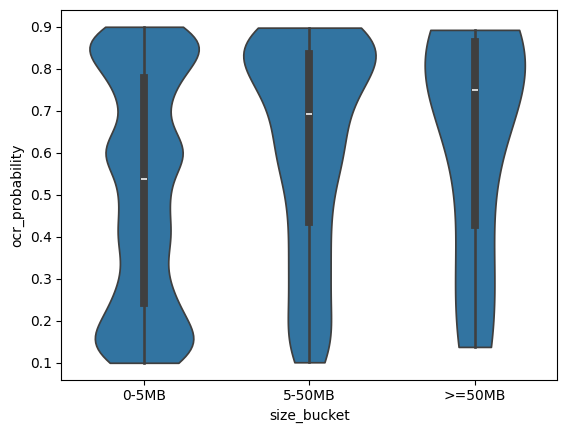

In [20]:
sns.violinplot(x="size_bucket", y="ocr_probability",
               data=df, cut=0)


(0.0, 1.0)

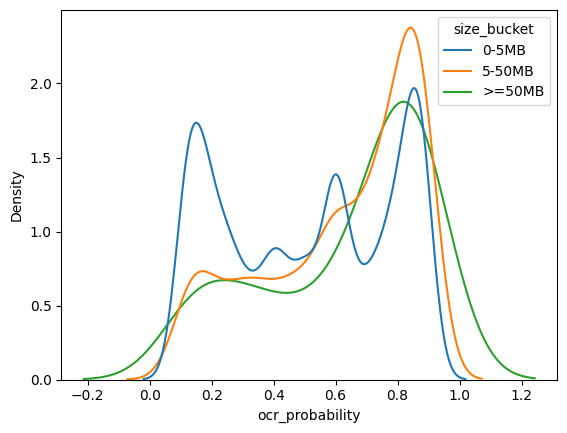

In [21]:
sns.kdeplot(data=df, x="ocr_probability", hue="size_bucket",
            common_norm=False, bw_adjust=0.8)
ax.set_xlim(0, 1)

<Axes: xlabel='ocr_probability', ylabel='Proportion'>

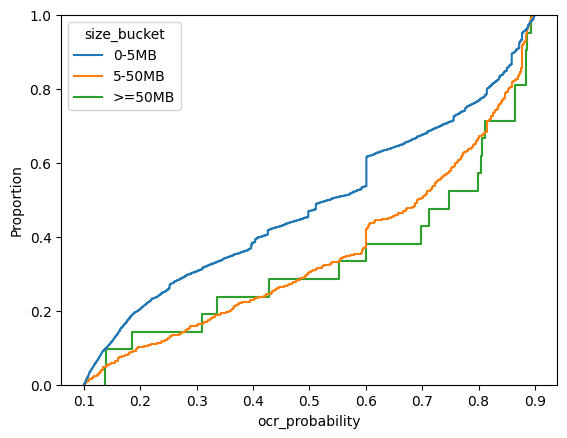

In [22]:
sns.ecdfplot(data=df, x="ocr_probability", hue="size_bucket")

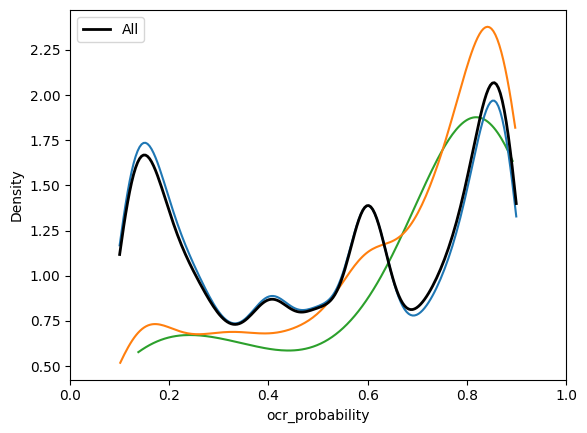

In [23]:
ax = sns.kdeplot(
    data=df, x="ocr_probability", hue="size_bucket",
    common_norm=False, bw_adjust=0.8,
    cut=0, clip=(0, 1)
)
sns.kdeplot(  # 叠加全部数据
    x=df["ocr_probability"],
    color="black", label="All", linewidth=2,
    bw_adjust=0.8, cut=0, clip=(0, 1), ax=ax
)
ax.set_xlim(0, 1)
ax.legend()

## 如果继续沿用0.2阈值。。。

会有大概80%的文件需要ocr，占总体积的86.7%

不同bucket需要ocr的比例：

```
size_bucket
0-5MB     0.795261
5-50MB    0.898488
>=50MB    0.857143
```


In [29]:
ocr_rate = (df['ocr_probability']>0.2).mean()
print(f"Proportion of files need ocr: {ocr_rate:.2%}")

Proportion of files need ocr: 80.45%


In [32]:
need_ocr_size = df[df['ocr_probability'] > 0.2].file_size_MB.sum()
total_size = df.file_size_MB.sum()
print(f"Total data size (MB): {total_size:.2f}")
print(f"Data size need ocr (MB): {need_ocr_size:.2f}")
print(f"Proportion of data size need ocr: {need_ocr_size/total_size:.2%}")

Total data size (MB): 11048.92
Data size need ocr (MB): 9584.01
Proportion of data size need ocr: 86.74%


In [33]:
df['need_ocr_old_threshold'] = df['ocr_probability'] > 0.2

In [43]:
df.groupby("size_bucket")["need_ocr_old_threshold"].mean()

/var/folders/8h/qygchvl97sd_mr0kglftbvp80000gn/T/ipykernel_54758/3762669762.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("size_bucket")["need_ocr_old_threshold"].mean()


size_bucket
0-5MB     0.795261
5-50MB    0.898488
>=50MB    0.857143
Name: need_ocr_old_threshold, dtype: float64

In [44]:
df.groupby("need_ocr_old_threshold")["size_bucket"].value_counts(normalize=True).unstack()

size_bucket,0-5MB,5-50MB,>=50MB
need_ocr_old_threshold,,,
False,0.951691,0.045411,0.002899
True,0.898122,0.097653,0.004225
